In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')


In [2]:
# 读取数据并简单处理数据
df_train = pd.read_excel(r'D:\\Advanced-Learning\\ML\\datasets\\traindata-new.xlsx')
df_test = pd.read_excel(r'D:\\Advanced-Learning\\ML\\datasets\\testdata-new.xlsx')

drop_cols = []
for col in df_test.columns:
    if df_test[col].notnull().sum() < 10:
        drop_cols.append(col)

df_train = df_train.drop(['DC50 (nM)', 'Dmax (%)'], axis=1)
df_test = df_test.drop(drop_cols, axis=1)
df_data = pd.concat([df_train, df_test], axis=0, ignore_index=True)
df_data = df_data.drop(drop_cols, axis=1)

In [3]:
train_missing_values = df_train.isnull().sum()
train_missing_percentage = (df_train.isnull().sum() / len(df_train)) * 100
test_missing_values = df_test.isnull().sum()
test_missing_percentage = (df_test.isnull().sum() / len(df_test)) * 100

train_missing_info = pd.DataFrame({'Missing Values': train_missing_values, 'Percentage': train_missing_percentage})
test_missing_info = pd.DataFrame({'Missing Values': test_missing_values, 'Percentage': test_missing_percentage})

# 删除缺失值超过 90% 的列
columns1=train_missing_info[train_missing_info['Percentage'] > 90].index
columns2=test_missing_info[test_missing_info['Percentage'] > 90].index
common_columns = set(columns1).intersection(set(columns2))
df_train = df_train.drop(columns=common_columns, axis=1)
df_test = df_test.drop(columns=common_columns, axis=1)
df_data = df_data.drop(columns=common_columns, axis=1)

In [4]:
### Smiles
'''   
从 Smiles 提取信息
'''
from rdkit import Chem
from rdkit.Chem import Descriptors

def extract_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        features = {
            'MolWt': Descriptors.MolWt(mol),
            'LogP': Descriptors.MolLogP(mol),
            'NumHDonors': Descriptors.NumHDonors(mol),
            'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        }
    else:
        features = {
            'MolWt': None,
            'LogP': None,
            'NumHDonors': None,
            'NumHAcceptors': None,
        }
    return features

def add_features(df):
    features_list = df['Smiles'].apply(extract_features)
    features_df = pd.DataFrame(features_list.tolist())
    df = pd.concat([df, features_df], axis=1)
    return df
df_data = add_features(df_data)

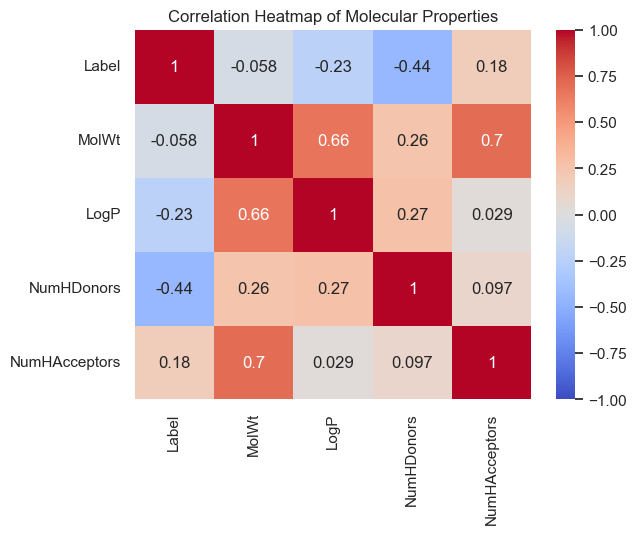

In [5]:
df_train = add_features(df_train)
### 在训练集上面查看新构造的特征与 Label 的关系
cols1 = ['Label', 'MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors']
df_train_simles = df_train[cols1]

# 计算相关系数矩阵
corr_matrix = df_train_simles.corr()

# 绘制相关性热图
plt.figure()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Molecular Properties')
plt.show()

In [6]:
# 对于 E3 ligase 进行标签编码
from sklearn.preprocessing import LabelEncoder
lbl_enc = LabelEncoder()
df_train.loc[:, "E3 ligase"] = lbl_enc.fit_transform(df_train['E3 ligase'].values)
df_train['E3 ligase'] = df_train['E3 ligase'].astype(int)


In [7]:
### Target
category_mapping = {
    'CDK': 'Kinase',
    'HDAC': 'Epigenetic',
    'BRAF': 'Kinase',
    'PARP': 'DNA Repair',
    'BRD': 'Epigenetic',
    'EGFR': 'Receptor',
    'BTK': 'Kinase',
    'JAK': 'Kinase',
    'AKT': 'Kinase',
    'ALK': 'Kinase',
    'AR': 'Receptor',
    'SMARC': 'Norem'
}

# 定义分类函数
def categorize_target(target):
    for key in category_mapping:
        if key in target:
            return category_mapping[key]
    return 'Other'
# 创建新的功能类别特征
df_train['Target'] = df_train['Target'].apply(categorize_target)

# 进行编码
lbl_enc = LabelEncoder()
df_train.loc[:, "Target"] = lbl_enc.fit_transform(df_train['Target'].values)
df_train['Target'] = df_train['Target'].astype(int)

